In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import networkx as nx
import matplotlib.pyplot as plt
from networkx import bipartite
import scipy


In [20]:

sp500_analysis = pd.ExcelFile("SP500_Analysis.xlsx")

financials_df = sp500_analysis.parse("Financials")
balance_sheets_df = sp500_analysis.parse("Balance_Sheets")
cashflow_df = sp500_analysis.parse("Cashflow")
profitability_df = sp500_analysis.parse("Profitability")
growth_df = sp500_analysis.parse("Growth")
Financial_health_df = sp500_analysis.parse("Financial_Health")
fundamental_df = sp500_analysis.parse("Valuation")

profitability_df["ticker"] = profitability_df["ticker"].ffill()
growth_df["ticker"] = growth_df["ticker"].ffill()
Financial_health_df["ticker"] = Financial_health_df["ticker"].ffill()
fundamental_df["ticker"] = fundamental_df["ticker"].ffill()
balance_sheets_df["ticker"] = balance_sheets_df["ticker"].ffill()

quarterly_features_df = (
    profitability_df[["ticker", "date", "ROE", "ROA", "Profit Margin", "Operating Margin", "Gross Margin"]]
    .merge(growth_df[["ticker", "date", "Revenue Growth", "Earnings Growth"]], on=["ticker", "date"], how="outer")
    .merge(Financial_health_df[["ticker", "date", "Debt Ratio", "Debt to Equity Ratio", "Current Ratio", "Free Cash Flow"]], on=["ticker", "date"], how="outer")
)

valuation_features_df = fundamental_df[["ticker", "trailingPE", "priceToBook", "enterpriseToEbitda", "marketCap", "dividendYield"]]

print(quarterly_features_df)
print(valuation_features_df)

# --------------------------------------------------------------------------
# having data for specific date 
# test_date_SP500_data = quarterly_features_df[quarterly_features_df['date'] == specific_date]

print(quarterly_features_df['date'].unique())

     ticker        date       ROE       ROA  Profit Margin  Operating Margin  \
0         A  2024-01-31       NaN       NaN            NaN               NaN   
1         A  2024-04-30  0.049565  0.028371       0.195804          0.230769   
2         A  2024-07-31  0.047772  0.025646       0.178707          0.211027   
3         A  2024-10-31  0.059512  0.029630       0.206349          0.239859   
4         A  2025-01-31  0.052763  0.026691       0.189173          0.223676   
...     ...         ...       ...       ...            ...               ...   
3253    XYZ  2024-06-30  0.010116  0.005201       0.031722          0.080963   
3254    XYZ  2024-09-30  0.014244  0.007805       0.047484          0.086193   
3255    XYZ  2024-12-31  0.091500  0.052913       0.322586          0.042707   
3256    XYZ  2025-03-31  0.008844  0.005217       0.032897          0.086453   
3257    XYZ  2025-06-30  0.024302  0.014609       0.088936          0.128564   

      Gross Margin  Revenue Growth  Ear

In [26]:
import networkx as nx

holdings = pd.read_csv("Warren_Buffett_final_df_with_ticker.csv")
fundamentals = pd.ExcelFile("Warren_Buffett_Analysis.xlsx")
SP500_quarterly_df = pd.read_csv("SP500_quarterly_data.csv")

form_filling_test_date = "2025-05-15"
quarter_date = "2025-03-31"

# Normalize holding dates to ISO strings so keys match YYYY-MM-DD format
holdings['date'] = pd.to_datetime(holdings['date'], errors='coerce')
holdings['date_str'] = holdings['date'].dt.strftime('%Y-%m-%d')

# ----------------------------
# Buffett’s holdings snapshots
# ----------------------------
snapshots = {}

for date_str, df in holdings.groupby('date_str'):
    G = nx.Graph()
    agg = df.groupby("ticker").agg({"shares": "sum", "value": "sum"}).reset_index()

    investor = "Buffett"
    G.add_node(investor, bipartite=0)

    for _, row in agg.iterrows():
        stock = row['ticker']
        G.add_node(stock, bipartite=1)
        G.add_edge(investor, stock, value=row['value'], shares=row['shares'])

    snapshots[date_str] = G

# ----------------------------
# Select the snapshot for the requested form date (robustly)
# ----------------------------
# If exact key not found, pick the most recent snapshot on or before the requested date.
if form_filling_test_date in snapshots:
    chosen_key = form_filling_test_date
else:
    form_dt = pd.to_datetime(form_filling_test_date)
    available = sorted([pd.to_datetime(d) for d in snapshots.keys() if pd.notnull(d)])
    chosen_dt = None
    for d in available:
        if d <= form_dt:
            chosen_dt = d
        else:
            break
    if chosen_dt is None and available:
        # fallback: pick latest available snapshot
        chosen_dt = available[-1]
    if chosen_dt is None:
        raise KeyError(f"No snapshots available to pick for date {form_filling_test_date}")
    chosen_key = chosen_dt.strftime('%Y-%m-%d')
    print(f"Warning: exact snapshot for {form_filling_test_date} not found. Using snapshot from {chosen_key} instead.")

G = snapshots[chosen_key]

# ----------------------------
# Add S&P500 quarterly features
# ----------------------------
# Ensure quarterly_features_df['date'] is comparable (ISO date string)
if not np.issubdtype(quarterly_features_df['date'].dtype, np.datetime64):
    quarterly_features_df['date'] = pd.to_datetime(quarterly_features_df['date'], errors='coerce')
test_date_SP500_data = quarterly_features_df[quarterly_features_df['date'] == pd.to_datetime(quarter_date)]

for _, row in test_date_SP500_data.iterrows():
    stock = row['ticker']

    if stock in G:
        continue

    G.add_node(
        stock,
        bipartite=1,
        roe=row.get('ROE'),
        roa=row.get('ROA'),
        profit_margin=row.get('Profit Margin'),
        operating_margin=row.get('Operating Margin'),
        gross_margin=row.get('Gross Margin'),
        revenue_growth=row.get('Revenue Growth'),
        earnings_growth=row.get('Earnings Growth'),
        debt_ratio=row.get('Debt Ratio'),
        debt_to_equity=row.get('Debt to Equity Ratio'),
        current_ratio=row.get('Current Ratio'),
        free_cash_flow=row.get('Free Cash Flow'),
    )

# ----------------------------
# Add valuation features
# ----------------------------
for _, row in valuation_features_df.iterrows():
    stock = row['ticker']
    if stock not in G:
        # add node if missing
        G.add_node(stock, bipartite=1)
    # use .get on pandas Series safely
    G.nodes[stock].update({
        'trailingPE': row.get('trailingPE') if hasattr(row, 'get') else row['trailingPE'],
        'priceToBook': row.get('priceToBook') if hasattr(row, 'get') else row['priceToBook'],
        'enterpriseToEbitda': row.get('enterpriseToEbitda') if hasattr(row, 'get') else row['enterpriseToEbitda'],
        'marketCap': row.get('marketCap') if hasattr(row, 'get') else row['marketCap'],
        'dividendYield': row.get('dividendYield') if hasattr(row, 'get') else row['dividendYield'],
    })

print("Final graph stats:")
print("Snapshot used:", chosen_key)
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())


Final graph stats:
Snapshot used: 2025-05-15
Total nodes: 510
Total edges: 36


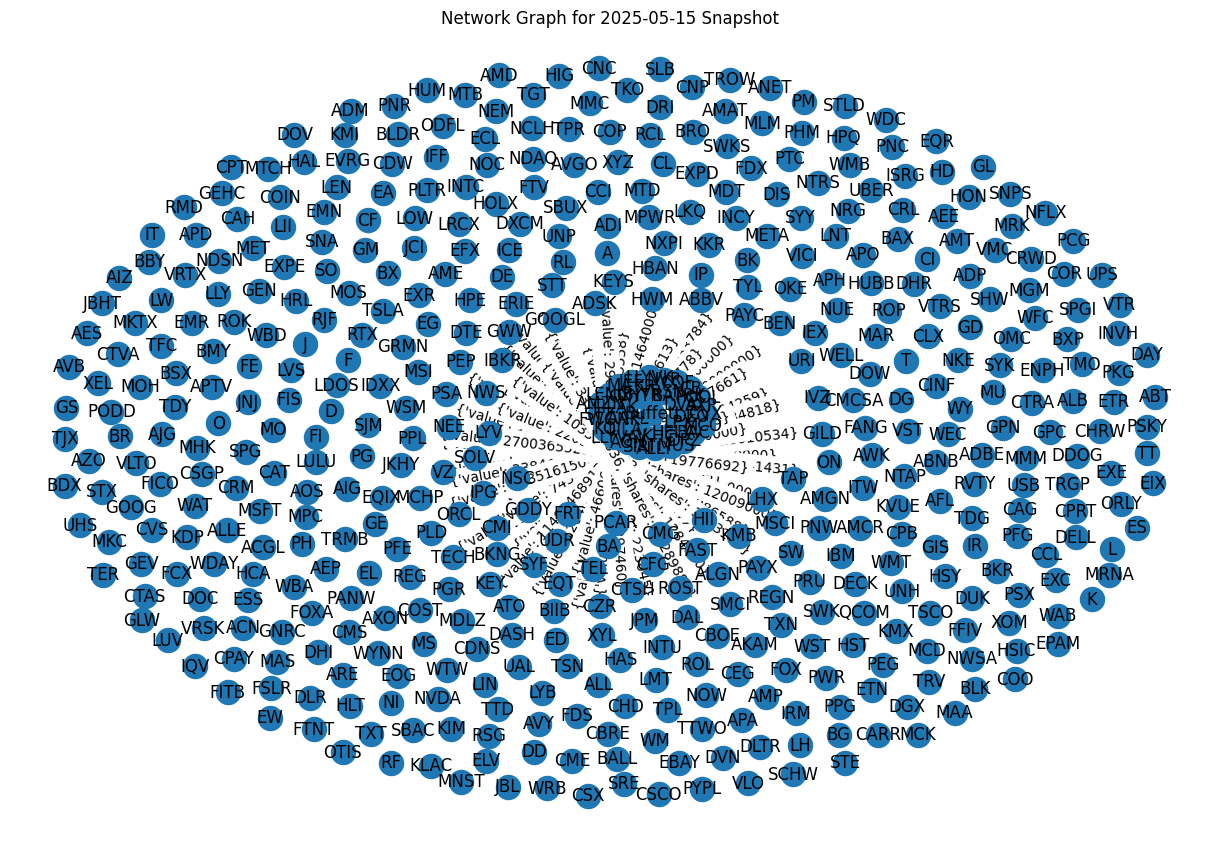

In [27]:
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))
plt.title(f"Network Graph for {'2025-05-15'} Snapshot")
plt.show()

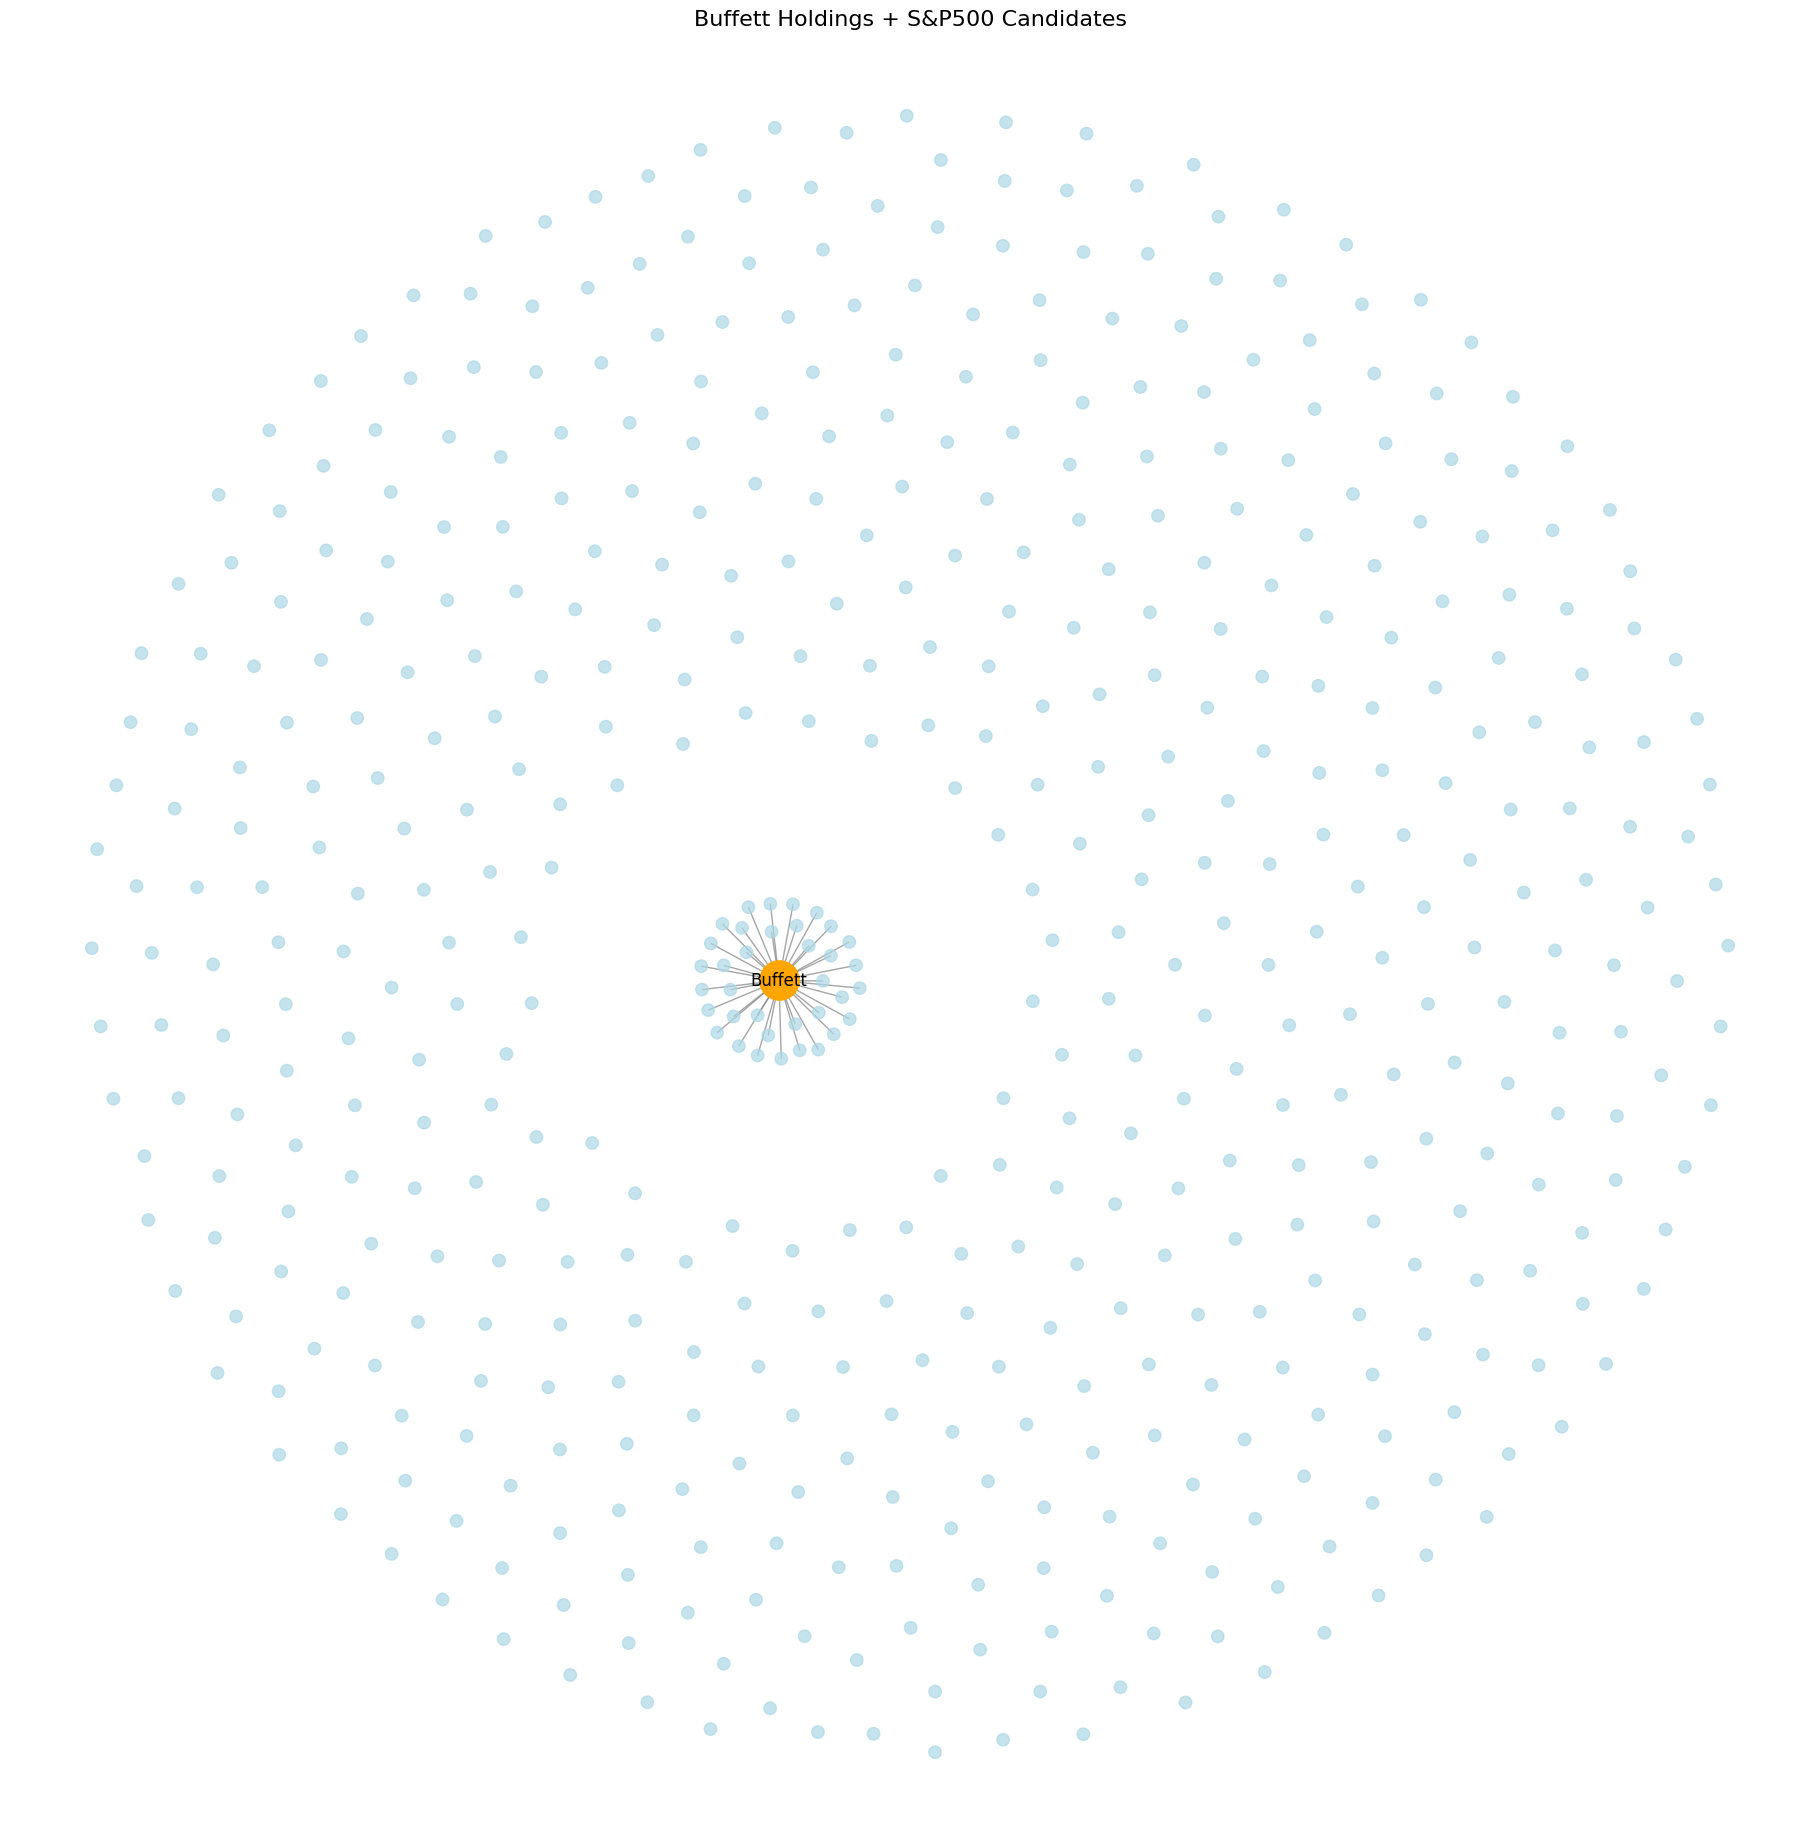

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(18, 18))

# Spring layout spreads nodes naturally
pos = nx.spring_layout(G, k=0.25, iterations=50, seed=42)

nx.draw(
    G, pos,
    with_labels=False,   # Hide labels (too many nodes). Set True if you want them.
    node_size=80,
    node_color=["lightblue" if d.get("bipartite") == 1 else "orange" for n, d in G.nodes(data=True)],
    edge_color="gray",
    alpha=0.7,
)

# Highlight Buffett in bigger size + label
nx.draw_networkx_nodes(G, pos, nodelist=["Buffett"], node_color="orange", node_size=800, label="Buffett")
nx.draw_networkx_labels(G, pos, labels={"Buffett": "Buffett"}, font_size=12, font_color="black")

plt.title("Buffett Holdings + S&P500 Candidates", fontsize=16)
plt.axis("off")
plt.show()


In [29]:
%pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -------------------------------

In [29]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, roc_auc_score)
import pandas as pd
import networkx as nx

import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import scipy


# ----------------------------
SP_feature_df = test_date_SP500_data.merge(valuation_features_df, on="ticker", how="left")
# print(feature_df)
# feature_df.to_csv("feature_df.csv", index=False)

# ----------------------------
# Buffett data preparation

# test_holding = holdings[holdings['date'] == form_filling_test_date]
# print(test_holding)

BF_financials_df = fundamentals.parse("Financials")
BF_balance_sheets_df = fundamentals.parse("Balance_Sheets")
BF_cashflow_df = fundamentals.parse("Cashflow")
BF_profitability_df = fundamentals.parse("Profitability")
BF_growth_df = fundamentals.parse("Growth")
BF_Financial_health_df = fundamentals.parse("Financial_Health")
BF_fundamental_df = fundamentals.parse("Valuation")

BF_profitability_df["ticker"] = BF_profitability_df["ticker"].ffill()
BF_growth_df["ticker"] = BF_growth_df["ticker"].ffill()
BF_Financial_health_df["ticker"] = BF_Financial_health_df["ticker"].ffill()
BF_fundamental_df["ticker"] = BF_fundamental_df["ticker"].ffill()
BF_balance_sheets_df["ticker"] = BF_balance_sheets_df["ticker"].ffill()

BF_quarterly_features_df = (
    BF_profitability_df[["ticker", "date", "ROE", "ROA", "Profit Margin", "Operating Margin", "Gross Margin"]]
    .merge(BF_growth_df[["ticker", "date", "Revenue Growth", "Earnings Growth"]], on=["ticker", "date"], how="outer")
    .merge(BF_Financial_health_df[["ticker", "date", "Debt Ratio", "Debt to Equity Ratio", "Current Ratio", "Free Cash Flow"]], on=["ticker", "date"], how="outer")
)

BF_valuation_features_df = BF_fundamental_df[["ticker", "trailingPE", "priceToBook", "enterpriseToEbitda", "marketCap", "dividendYield"]]
# ----------------------------
BF_test_df = BF_quarterly_features_df[BF_quarterly_features_df['date'] == quarter_date].merge(BF_valuation_features_df, on="ticker", how="left")
print(BF_test_df)
# print(BF_quarterly_features_df)
# print(BF_valuation_features_df)
# ---------------------------


# Merging all features together - to create label col
BF_test_df['date'] = pd.to_datetime(BF_test_df['date'])
# test_date_SP500_data['date'] = pd.to_datetime(test_date_SP500_data['date'])

final_feature_df = BF_test_df.merge(SP_feature_df, how="outer")
# print(final_feature_df)

# final_feature_df.to_csv("final_feature_df.csv", index=False)


# ------------------------------------------------------------------


buffett_holdings = holdings[holdings['date'] == form_filling_test_date]['ticker'].unique()

# ----------------------------
# Add label column: 1 if Buffett held, else 0
final_feature_df['label'] = final_feature_df['ticker'].isin(buffett_holdings).astype(int)

# ----------------------------
print(final_feature_df[['ticker', 'label']].head())
print("✅ Buffett held:", final_feature_df['label'].sum(), "stocks on", form_filling_test_date)
print("✅ Total stocks in dataset:", len(final_feature_df))
# final_feature_df.to_csv("final_feature_df.csv", index=False)


   ticker       date       ROE       ROA  Profit Margin  Operating Margin  \
0    AAPL 2025-03-31  0.370980  0.074811       0.259860          0.310291   
1    ALLY 2025-03-31 -0.018895 -0.001164      -0.128205               NaN   
2    AMZN 2025-03-31  0.055995  0.026625       0.110023          0.118233   
3     AON 2025-03-31  0.137778  0.019183       0.204060          0.327342   
4     AXP 2025-03-31  0.082815  0.009155       0.152296               NaN   
5     BAC 2025-03-31  0.026887  0.002208       0.270262               NaN   
6   BATRK 2025-03-31 -0.085145 -0.024616      -0.876724         -0.941560   
7       C 2025-03-31  0.020942  0.001580       0.188139               NaN   
8      CB 2025-03-31  0.020251  0.005287       0.098739               NaN   
9    CHTR 2025-03-31  0.074906  0.008062       0.088606          0.244631   
10    COF 2025-03-31  0.022096  0.002844       0.140400               NaN   
11    CVX 2025-03-31  0.023452  0.013651       0.075920          0.093208   

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, roc_auc_score)
import pandas as pd
import networkx as nx

import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import scipy


# ----------------------------
# Features and Labels
final_feature_df = pd.read_csv("final_feature_df.csv")

X = final_feature_df.drop(columns=['ticker', 'date', 'label'])
y = final_feature_df['label']
X = final_feature_df.drop(columns=["ticker", "label", "date"]).replace([np.inf, -np.inf], np.nan)


# ----------------------------
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ----------------------------
# Pipeline: Imputer + Scaler + Classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
# ----------------------------
# Train the model
pipeline.fit(X_train, y_train)
y_predictions = pipeline.predict(X_test)

# ----------------------------
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predictions))
print("\nClassification Report:\n", classification_report(y_test, y_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, y_predictions))


Confusion Matrix:
 [[83  1]
 [ 6  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96        84
           1       0.00      0.00      0.00         6

    accuracy                           0.92        90
   macro avg       0.47      0.49      0.48        90
weighted avg       0.87      0.92      0.90        90

ROC AUC Score: 0.49404761904761907


In [8]:
%pip install xgboost
%pip install imbalanced-learn

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.4 MB/s eta 0:00:40
    --------------------------------------- 1.3/56.8 MB 2.2 MB/s eta 0:00:26
   - -------------------------------------- 1.6/56.8 MB 2.2 MB/s eta 0:00:26
   - -------------------------------------- 1.6/56.8 MB 2.2 MB/s eta 0:00:26
   - -------------------------------------- 2.1/56.8 MB 1.8 MB/s eta 0:00:31
   - -------------------------------------- 2.1/56.8 MB 1.8 MB/s eta 0:00:31
   - -------------------------------------- 2.4/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 2.4/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 2.4/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 2.6/56.8 MB 1.1 MB/s eta 0:00:49
   -- --------------

In [25]:
# Random Forrest with SMOTE to handle class imbalance

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# ----------------------------
# Features and Labels
final_feature_df = pd.read_csv("final_feature_df.csv")
positive_idx = final_feature_df[final_feature_df['label'] == 1].index
negative_idx = final_feature_df[final_feature_df['label'] == 0].index

neg_train_idx, neg_test_idx = train_test_split(negative_idx, test_size=0.2, random_state=42)

# Split positive samples: 2 for test, rest for train
pos_train_idx, pos_test_idx = train_test_split(positive_idx, test_size=2, random_state=42)

# Combine with negative train/test
train_idx = pos_train_idx.union(neg_train_idx)
test_idx = pos_test_idx.union(neg_test_idx)

X_train = final_feature_df.loc[train_idx].drop(columns=['ticker','date','label'])
y_train = final_feature_df.loc[train_idx]['label']

X_test = final_feature_df.loc[test_idx].drop(columns=['ticker','date','label'])
y_test = final_feature_df.loc[test_idx]['label']

# ----------------------------
# Fix infinite values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Clip extreme outliers (1st and 99th percentile)
for col in X_train.select_dtypes(include=[np.number]).columns:
    q_low, q_hi = X_train[col].quantile([0.01, 0.99])
    X_train[col] = X_train[col].clip(q_low, q_hi)
    X_test[col] = X_test[col].clip(q_low, q_hi)



# ----------------------------
# Preprocessing: Imputer + Scaler
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# ----------------------------
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# ----------------------------
# Train classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train_bal, y_train_bal)

# ----------------------------
# Evaluate on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ----------------------------
# Rank non-Buffett stocks in test set
X_test_with_ticker = final_feature_df.loc[test_idx, ['ticker', 'label']].copy()
X_test_with_ticker['score'] = y_proba
potential_buys = X_test_with_ticker[X_test_with_ticker['label'] == 0].sort_values(by='score', ascending=False)
print("Top potential buys (test set):\n", potential_buys.head(10))


Confusion Matrix:
 [[82  2]
 [ 0  2]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        84
           1       0.50      1.00      0.67         2

    accuracy                           0.98        86
   macro avg       0.75      0.99      0.83        86
weighted avg       0.99      0.98      0.98        86

ROC AUC Score: 1.0
Top potential buys (test set):
     ticker  label     score
291    MTD      0  0.848495
347    RCL      0  0.723045
29     AOS      0  0.413256
62       C      0  0.384418
436    WFC      0  0.284744
443   WYNN      0  0.252873
284   MRNA      0  0.248333
10     AFL      0  0.162785
86     CMS      0  0.150540
1     ABBV      0  0.128199


c:\1.Revanth\Projects\Project-WB\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:46:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
# ----------------------------
# SP500 prediction (no SMOTE applied here)
sp500_test_df = final_feature_df[final_feature_df['label'] == 0].copy()
X_sp500 = sp500_test_df.drop(columns=['ticker', 'date', 'label'])

# Preprocess SP500 data
X_sp500_imputed = imputer.transform(X_sp500)
X_sp500_scaled = scaler.transform(X_sp500_imputed)

# Predict probability of being "Buffett-like"
sp500_test_df['score'] = clf.predict_proba(X_sp500_scaled)[:, 1]
sp500_test_df = sp500_test_df.sort_values(by='score', ascending=False)

top_potential_buys = sp500_test_df[['ticker', 'score']].head(10)
print("Top potential buys (SP500):\n", top_potential_buys)

Top potential buys (SP500):
     ticker     score
291    MTD  0.848495
347    RCL  0.723045
29     AOS  0.413256
62       C  0.384418
436    WFC  0.284744
443   WYNN  0.252873
284   MRNA  0.248333
10     AFL  0.162785
86     CMS  0.150540
1     ABBV  0.128199


In [27]:
# Random Forest / XGBoost with class weights

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ----------------------------
# Features and Labels
final_feature_df = pd.read_csv("final_feature_df.csv")
positive_idx = final_feature_df[final_feature_df['label'] == 1].index
negative_idx = final_feature_df[final_feature_df['label'] == 0].index

neg_train_idx, neg_test_idx = train_test_split(negative_idx, test_size=0.2, random_state=42)
# Split positive samples: 2 for test, rest for train
pos_train_idx, pos_test_idx = train_test_split(positive_idx, test_size=2, random_state=42)

# Combine with negative train/test
train_idx = pos_train_idx.union(neg_train_idx)
test_idx = pos_test_idx.union(neg_test_idx)

X_train = final_feature_df.loc[train_idx].drop(columns=['ticker','date','label'])
y_train = final_feature_df.loc[train_idx]['label']

X_test = final_feature_df.loc[test_idx].drop(columns=['ticker','date','label'])
y_test = final_feature_df.loc[test_idx]['label']

# ----------------------------
# Fix infinite values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Clip extreme outliers (1st and 99th percentile)
for col in X_train.select_dtypes(include=[np.number]).columns:
    q_low, q_hi = X_train[col].quantile([0.01, 0.99])
    X_train[col] = X_train[col].clip(q_low, q_hi)
    X_test[col] = X_test[col].clip(q_low, q_hi)

# ----------------------------
# Preprocessing: Imputer + Scaler
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# ----------------------------
# Compute scale_pos_weight for XGBoost
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# ----------------------------
# Train classifier with class weights
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
clf.fit(X_train_scaled, y_train)

# ----------------------------
# Evaluate on test set
y_pred = clf.predict(X_test_scaled)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ----------------------------
# Rank non-Buffett stocks in test set
X_test_with_ticker = final_feature_df.loc[test_idx, ['ticker', 'label']].copy()
X_test_with_ticker['score'] = y_proba
potential_buys = X_test_with_ticker[X_test_with_ticker['label'] == 0].sort_values(by='score', ascending=False)
print("Top potential buys (test set):\n", potential_buys.head(10))


Confusion Matrix:
 [[81  3]
 [ 2  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        84
           1       0.00      0.00      0.00         2

    accuracy                           0.94        86
   macro avg       0.49      0.48      0.49        86
weighted avg       0.95      0.94      0.95        86

ROC AUC Score: 0.7976190476190477
Top potential buys (test set):
     ticker  label     score
1     ABBV      0  0.758667
291    MTD      0  0.737407
347    RCL      0  0.585419
284   MRNA      0  0.285743
62       C      0  0.253019
405   TTWO      0  0.094806
123    DVN      0  0.081593
92     COR      0  0.058403
161   FICO      0  0.032409
24     AMP      0  0.027849


c:\1.Revanth\Projects\Project-WB\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:49:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [28]:
# ----------------------------
# SP500 prediction (no SMOTE applied here)
sp500_test_df = final_feature_df[final_feature_df['label'] == 0].copy()
X_sp500 = sp500_test_df.drop(columns=['ticker', 'date', 'label'])

# Preprocess SP500 data
X_sp500_imputed = imputer.transform(X_sp500)
X_sp500_scaled = scaler.transform(X_sp500_imputed)

# Predict probability of being "Buffett-like"
sp500_test_df['score'] = clf.predict_proba(X_sp500_scaled)[:, 1]
sp500_test_df = sp500_test_df.sort_values(by='score', ascending=False)

top_potential_buys = sp500_test_df[['ticker', 'score']].head(10)
print("Top potential buys (SP500):\n", top_potential_buys)

Top potential buys (SP500):
     ticker     score
1     ABBV  0.758667
291    MTD  0.737407
347    RCL  0.585419
284   MRNA  0.285743
62       C  0.253019
405   TTWO  0.094806
123    DVN  0.081593
286   MSCI  0.065568
235   KLAC  0.060959
92     COR  0.058403
